In [1]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, kurtosis, skew, boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import warnings
from time import perf_counter
import joblib

In [2]:
data = pd.read_csv("../../Data/Bank_Marketing.csv")
print("Few rows of the dataset")
data

Few rows of the dataset


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45203,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45204,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45205,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
print(f'The shape of Dataset:\nNumber of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}')

The shape of Dataset:
Number of rows: 45207
Number of columns: 17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45207 entries, 0 to 45206
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45207 non-null  int64 
 1   job        45207 non-null  object
 2   marital    45207 non-null  object
 3   education  45207 non-null  object
 4   default    45207 non-null  object
 5   balance    45207 non-null  int64 
 6   housing    45207 non-null  object
 7   loan       45207 non-null  object
 8   contact    45207 non-null  object
 9   day        45207 non-null  int64 
 10  month      45207 non-null  object
 11  duration   45207 non-null  int64 
 12  campaign   45207 non-null  int64 
 13  pdays      45207 non-null  int64 
 14  previous   45207 non-null  int64 
 15  poutcome   45207 non-null  object
 16  y          45207 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
print(f'Null values in each column:\n\n{data.isnull().sum()}')

Null values in each column:

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


<p style = "color:black"; "font-family:Times New Roman"
>The data.isnull() method indicates that this dataset has no <b>missing values</b>.
However, it is important to investigate <b>Unknown</b> values in different features.</p>

In [6]:
print("\nSummary statistics for numerical features:")
data.describe()


Summary statistics for numerical features:


,age,balance,day,duration,campaign,pdays,previous
count,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000
mean,40.936315,1362.246798,15.806357,258.178202,2.763576,40.195656,0.574292
std,10.618940,3044.825898,8.322256,257.530264,3.097614,100.127179,1.907985
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,58.000000


<span style = "color:black">Insights from Dataset Description
The dataset description provides valuable insights into the distribution ans statistics of the numerical features:  
1. __Age:__
   * The mean age of clients is approximately 41 years.
   * The age of clients ranges from 18 to 95 years.
   * the majority of clients are between the age of 33 and 48.

2. __Balance:__
   * The mean account balance is approximately 1362 euros.
   * The account balance varies widely, ranging from -8019 to 102127 euros.
   * The distribution of account balances is skewed, with a large standard deviation of 3044,77.

3. __Day:__  
   * The mean last contact day of the month is approximately 16.

4. __Duration:__
   * The mean duration of the last contact is approximately 258 seconds.
   * The duration of the last contact ranges from 0 to 4918 seconds.
   * The distribution of contact duration is right-skewed, with a large standard deviation of 257.

5. __Campaign:__
   * The mean number of contacts performed during the current campaign is approximately 3.
   * The number of campaign contacts ranges from 1 to 63.

6. __Pdays (Number of days since the client was last contacted from a previous campaign):__  
   * The mean number of days since the client was last contacted is approximately 40 days.
   * A negative value (-1) indicates that the client was not previously contacted.

7. __Previous (Number of contacts performed before this campaign for the client):__
   * The number of previous contacts ranges from 0 to 275.
   * The majority of clients were not contacted before this campaign, as indicated by the 75th percentile.
</span>

In [7]:
#Selects all the columns that are of type numerical
num_col = data.select_dtypes(include=['int64']).columns

# Calculate mean and trimmed mean for each numeric columns
mean_vs_trimmed_mean = pd.DataFrame({'mean' : data[num_col].mean(),
                                    'trimmed_mean': data[num_col].
                                    apply(lambda x: trim_mean(x, proportiontocut=0.1))})

# Calculate kurtosis and skewness for each numeric columns
kurtosis_skewness = pd.DataFrame({'kurtosis': data[num_col].apply(kurtosis),
                                'skewness': data[num_col].apply(skew)})

print('Trimmed Mean vs Mean:')
mean_vs_trimmed_mean

Trimmed Mean vs Mean:


,mean,trimmed_mean
age,40.936315,40.251998
balance,1362.246798,767.225482
day,15.806357,15.687201
duration,258.178202,210.886775
campaign,2.763576,2.119805
pdays,40.195656,11.916913
previous,0.574292,0.129953


In [8]:
print("\nKurtosis and Skewness")
kurtosis_skewness


Kurtosis and Skewness


,kurtosis,skewness
age,0.319391,0.684781
balance,140.737422,8.360246
day,-1.059825,0.093124
duration,18.152035,3.144292
campaign,39.267417,4.899745
pdays,6.935489,2.615812
previous,110.845554,7.829590


### Insights

1. __Age:__

    The distribution of age is slightly right-skewed. The kurtosis values is close to 0, indicating a distribution that is close to normal.

2. __Balance:__

    The balance data is heavily right-skewed with a very high positive skewness (8.36) and positive kurtosis (140.74). This suggests that there are __many customers with a low balances__ and a __few customers with very high balance.__

3. __Duration:__

    The duration of the last contact is moderately rigth-skewed with a positive skewness of 3.14 and high positive kurtosis of 18.15. This indicates that there are some very long durations, potentially __outliers__, in the dataset.

4. __Campaign and Previous:__

    Both campaign and previous features have high positive skewness and kurtosis values, indicating __highly skewed distributions__ with heavy tails, potentially due to outliers.

In [9]:
print("\nSummary statistics for categorical features:")
data.describe(include='O')


Summary statistics for categorical features:


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45207,45207,45207,45207,45207,45207,45207,45207,45207,45207
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27210,23200,44392,25127,37964,29282,13764,36956,39918


In [10]:
print(f'Unique values in each column:\n{data.nunique()}')

Unique values in each column:
age            77
job            12
marital         3
education       4
default         2
balance      7167
housing         2
loan            2
contact         3
day            31
month          12
duration     1572
campaign       48
pdays         559
previous       40
poutcome        4
y               2
dtype: int64


In [11]:
#Detecting if there are duplicate rows
data.duplicated().sum()

0

### Insights

+ There are no duplicate records in the dataset, indicating each entry is unique.
+ Also, we can see the most common value in each categorical feature.
+ According to the above results, we can conclude that:
    1. Married individuals are the most prevalent group in the dataset.
    2. A large portion of clients have completed secondary schooling.
    3. Most individuals did not subscribe to the service or product offered. This fact demonstrates that the label of this dataset is not balanced.

# Eda and Visualization 

## Categorical Features

In [12]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

The __y__ column it's goint to be rename to subcrided due to clean coding

In [13]:
data.rename(columns={'y' : 'subscribed'}, inplace=True)

In [14]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
            'month', 'poutcome', 'subscribed']

for col in cat_cols:
    print(f"Percentage of each unique value in column '{col}':")
    value_counts = data[col].value_counts(normalize=True)*100
    value_counts = value_counts.round(2).astype(str) + '%'
    print(value_counts)
    print('='*50)
    print()

Percentage of each unique value in column 'job':
job
blue-collar       21.53%
management        20.92%
technician         16.8%
administrative    11.44%
services           9.19%
retired            5.01%
self-employed      3.49%
entrepreneur       3.29%
unemployed         2.88%
housemaid          2.74%
student            2.07%
unknown            0.64%
Name: proportion, dtype: object

Percentage of each unique value in column 'marital':
marital
married     60.19%
single      28.29%
divorced    11.52%
Name: proportion, dtype: object

Percentage of each unique value in column 'education':
education
secondary    51.32%
tertiary     29.42%
primary      15.15%
unknown       4.11%
Name: proportion, dtype: object

Percentage of each unique value in column 'default':
default
no     98.2%
yes     1.8%
Name: proportion, dtype: object

Percentage of each unique value in column 'housing':
housing
yes    55.58%
no     44.42%
Name: proportion, dtype: object

Percentage of each unique value in column '

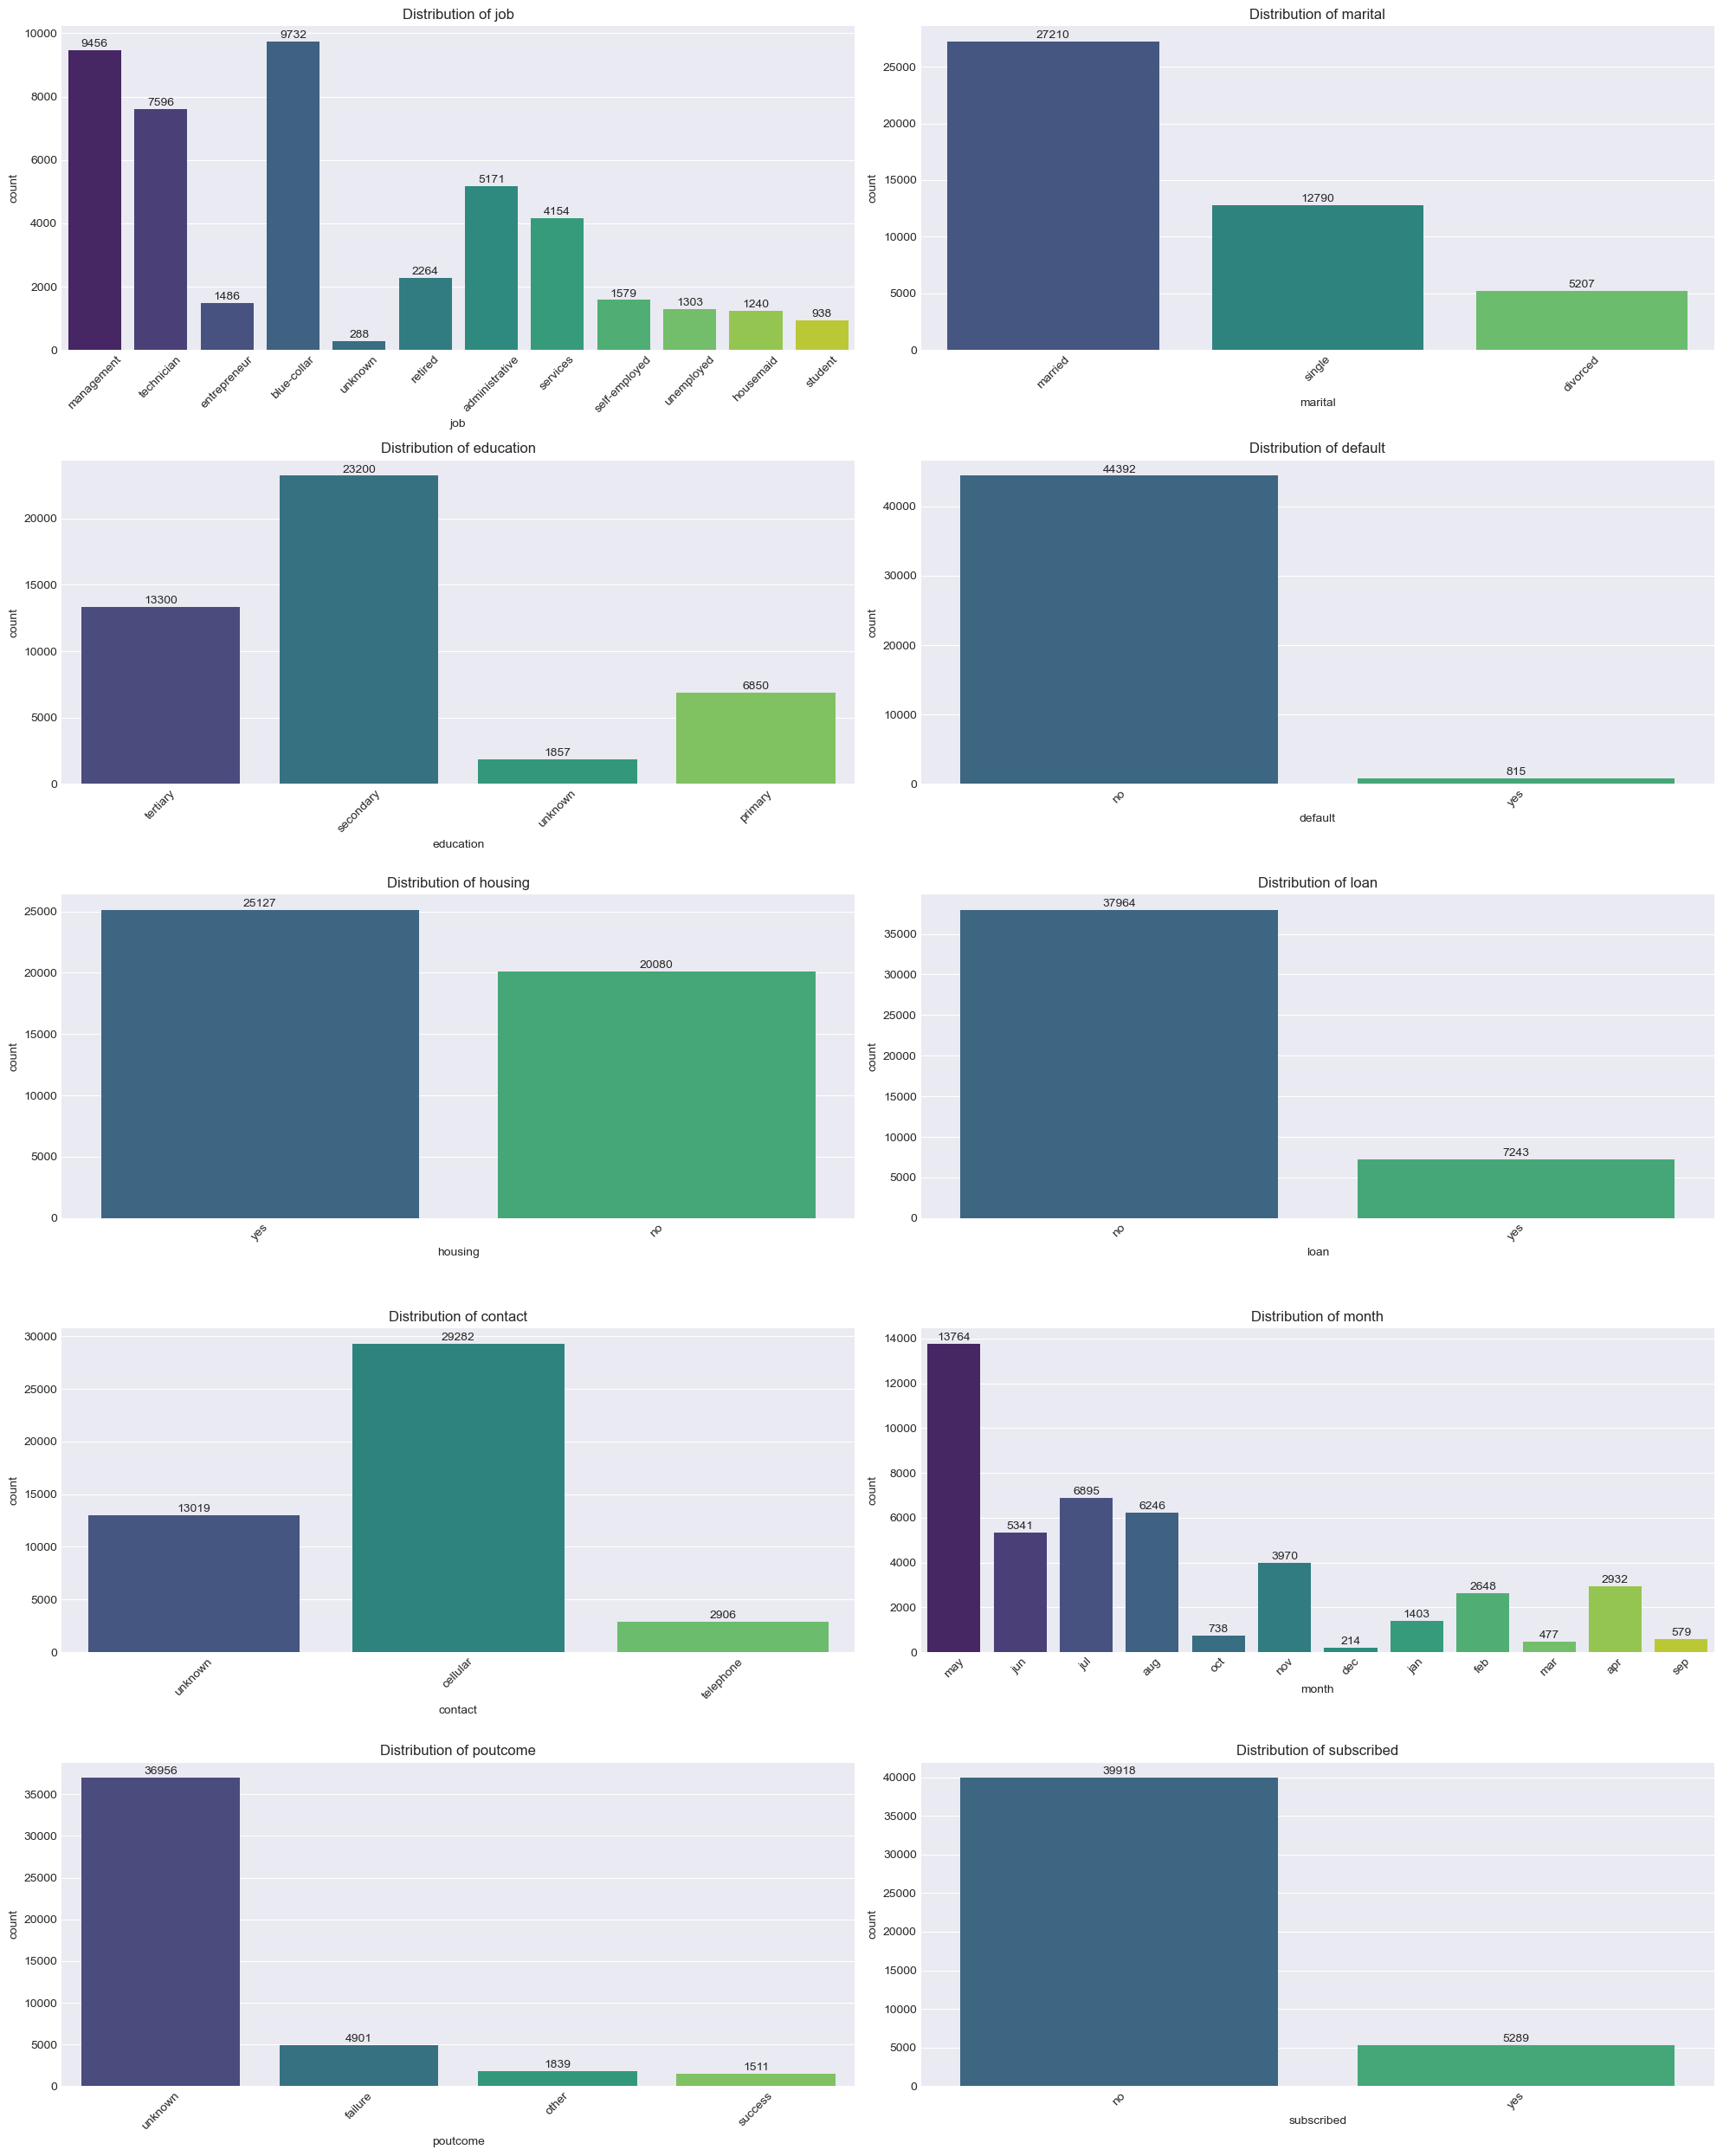

In [15]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(5, 2, figsize=(20,25))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        x = col,
        data = data,
        ax = ax[i],
        palette='viridis'
    )
    ax[i].set_title(f'Distribution of {col}')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 45)
    
    for p in ax[i].patches:
        ax[i].annotate(f'{int(p.get_height())}', 
                    (p.get_x()+p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    fontsize = 10,
                    xytext = (0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

__Inights__

* __Blue-collar__ and __management__ are the most common jobs in this dataset.
* The majority of clients have no credit in default.
* The most of contacts occured in may.
* Furthermore These results confirm that ground truth is __imbalanced__.
* We can see that __job, education, contact__, and __poutcome__ features have __unknown__ values. so, It is important to handle them before any other act on data.

## Handling Unknown Values

In [17]:
unknown_col = ['job', 'education', 'contact', 'poutcome']

for col in unknown_col:
    unknown_counter = data[col].eq('unknown').sum()
    print()
    print(f"Number of 'unknown' values in {col}: {unknown_counter}")
    print()


Number of 'unknown' values in job: 288


Number of 'unknown' values in education: 1857


Number of 'unknown' values in contact: 13019


Number of 'unknown' values in poutcome: 36956



Before handling unknown values, it's going to be determine the only rows where __'pdays'__ is -1 and __'previous'__ is 0, indicating that the client was not previously contacted. According to the dataset information, __unknown__ values of __poutcome__ column only present the clients who are in the __new campaign__. The following code snippet checks this case for us:

In [21]:
#Handling Unknown Values in 'poutcome'
#checking the clients just in the new campaign

new_camp = data[(data['pdays'] == -1) & (data['previous'] == 0)]
print('new campaign clients:', len(new_camp))

print()

# unkown values in 'poutcome'
print("unknown values in 'poutcome' column: ", len(data[data['poutcome'] == 'unknown']))

new campaign clients: 36951

unknown values in 'poutcome' column:  36956


__Insights__

Based on the information provided, there are indeed __5 null values__ in the __poutcome__ column. This is inferred from the fact that the number of rows where pdays is -1 (indicating clients not previously contacted) is __36951__, and the number of unknown values in the __poutcome__ column is __36956__.

In [23]:
# Replace 36951 occurrences of "unknown" with "Not Applicable"
data.loc[data['pdays'] == -1, 'poutcome'] = 'Not Applicable'

# Replace the other unknown values with np.nan in the dataset
data.replace('unknown', np.nan, inplace=True)

#Verify the changes
print(data['poutcome'].value_counts())
print()
print(data.isnull().sum())

poutcome
Not Applicable    36951
failure            4901
other              1839
success            1511
Name: count, dtype: int64

age               0
job             288
marital           0
education      1857
default           0
balance           0
housing           0
loan              0
contact       13019
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          5
subscribed        0
dtype: int64
